"""
Enhanced Synthetic Data Generator with improved performance, maintainability, and flexibility.
Supports both DataFrame input and file-based processing with efficient memory management.
"""

<a id = 'Index:'></a>

# Table of Contents


- [Part 1.1 - Synthetic Data Generation - Classes Define](#pa11ne)
- [Part 1.2 - Synthetic Data Generation - Execution](#p12ion)
- [Part 3 - Data Exploratory Analysis](#3ysis)
- [End](#end)



In [1]:

import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import os
import glob
import time
from datetime import datetime

from pathlib import Path
from typing import Union, List, Optional, Dict, Any
from dataclasses import dataclass, field
from contextlib import contextmanager
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer

In [2]:
# Configure timestamp callback for Jupyter cells
from IPython import get_ipython

def setup_timestamp_callback():
    """Setup a timestamp callback for Jupyter cells without clearing existing callbacks."""
    ip = get_ipython()
    if ip is not None:
        # Define timestamp function
        def print_timestamp(*args, **kwargs):
            """Print timestamp after cell execution."""
            print(f"Cell executed at: {datetime.now()}")
        
        # Check if our callback is already registered
        callbacks = ip.events.callbacks.get('post_run_cell', [])
        for cb in callbacks:
            if hasattr(cb, '__name__') and cb.__name__ == 'print_timestamp':
                # Already registered
                return
                
        # Register new callback if not already present
        ip.events.register('post_run_cell', print_timestamp)
        print("Timestamp printing activated.")
    else:
        print("Not running in IPython/Jupyter environment.")

# Setup timestamp callback
setup_timestamp_callback()

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

Timestamp printing activated.
Cell executed at: 2025-07-09 16:09:29.566121


[Back to top](#Index:)

<a id='part11'></a>

## Part 1.1 - Synthetic Data Generation - Classes Define


In [3]:
# Configure timestamp callback for Jupyter cells
def setup_timestamp_callback():
    """Setup a timestamp callback for Jupyter cells without clearing existing callbacks."""
    try:
        from IPython import get_ipython
        
        ip = get_ipython()
        if ip is not None:
            # Define timestamp function
            def print_timestamp(*args, **kwargs):
                """Print timestamp after cell execution."""
                print(f"Cell executed at: {datetime.now()}")

            # Check if our callback is already registered
            callbacks = ip.events.callbacks.get('post_run_cell', [])
            for cb in callbacks:
                if hasattr(cb, '__name__') and cb.__name__ == 'print_timestamp':
                    # Already registered
                    return

            # Register new callback if not already present
            ip.events.register('post_run_cell', print_timestamp)
            print("Timestamp printing activated.")
        else:
            print("Not running in IPython/Jupyter environment.")
    except ImportError:
        print("IPython not available - timestamp callback not set up.")

# Setup timestamp callback
setup_timestamp_callback()


@dataclass
class SyntheticDataConfig:
    """Configuration class for synthetic data generation parameters - all variables passed through."""
    
    # File paths - all required, no defaults
    seed_file_path: str
    output_file_path: str
    metadata_file_path: str
    
    # Processing parameters
    num_samples: int
    categorical_cols: List[str]
    
    # Optional parameters with defaults
    optimize_memory: bool = True
    save_metadata: bool = True


class SyntheticDataProcessor:
    """
    Variable-based synthetic data generator with no hardcoded paths.
    
    Features:
    - All file paths passed as variables
    - No assumptions about folder structure
    - Memory efficient processing
    - Comprehensive logging and error handling
    """
    
    def __init__(self):
        """Initialize the processor with minimal setup."""
        self.logger = self._setup_logging()
        self.metadata: Optional[SingleTableMetadata] = None
        self.synthesizer: Optional[GaussianCopulaSynthesizer] = None
    
    def _setup_logging(self) -> logging.Logger:
        """Configure logging for the processor."""
        logger = logging.getLogger(__name__)
        logger.setLevel(logging.INFO)
        
        if not logger.handlers:
            handler = logging.StreamHandler()
            formatter = logging.Formatter(
                '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
            )
            handler.setFormatter(formatter)
            logger.addHandler(handler)
        
        return logger
    
    @contextmanager
    def _performance_timer(self, operation_name: str):
        """Context manager for timing operations."""
        start_time = time.time()
        self.logger.info(f"Starting {operation_name}...")
        try:
            yield
            elapsed = time.time() - start_time
            self.logger.info(f"✓ {operation_name} completed in {elapsed:.2f}s")
        except Exception as e:
            elapsed = time.time() - start_time
            self.logger.error(f"✗ {operation_name} failed after {elapsed:.2f}s: {e}")
            raise
    
    def load_data(self, file_path: str) -> pd.DataFrame:
        """
        Load data from the specified file path.
        
        Args:
            file_path: Complete file path to load data from
            
        Returns:
            pandas DataFrame with the loaded data
            
        Raises:
            FileNotFoundError: If file doesn't exist
        """
        file_path = Path(file_path)
        
        if not file_path.exists():
            raise FileNotFoundError(f"Data file not found: {file_path}")
        
        with self._performance_timer(f"Loading data from {file_path.name}"):
            df = pd.read_csv(file_path, low_memory=False)
            self.logger.info(f"Loaded {len(df)} rows, {len(df.columns)} columns")
            return df
    
    def _optimize_dataframe_memory(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Optimize DataFrame memory usage without creating duplicates.
        
        Args:
            df: Input DataFrame to optimize
            
        Returns:
            Memory-optimized DataFrame (same object, modified in-place)
        """
        with self._performance_timer("Memory optimization"):
            initial_memory = df.memory_usage(deep=True).sum() / 1024**2
            
            # Optimize numeric columns
            for col in df.select_dtypes(include=['int64']).columns:
                col_min, col_max = df[col].min(), df[col].max()
                if col_min >= 0:
                    if col_max < 255:
                        df[col] = df[col].astype('uint8')
                    elif col_max < 65535:
                        df[col] = df[col].astype('uint16')
                    elif col_max < 4294967295:
                        df[col] = df[col].astype('uint32')
                else:
                    if col_min > -128 and col_max < 127:
                        df[col] = df[col].astype('int8')
                    elif col_min > -32768 and col_max < 32767:
                        df[col] = df[col].astype('int16')
                    elif col_min > -2147483648 and col_max < 2147483647:
                        df[col] = df[col].astype('int32')
            
            # Optimize float columns
            for col in df.select_dtypes(include=['float64']).columns:
                df[col] = pd.to_numeric(df[col], downcast='float')
            
            # Convert object columns to category where beneficial
            for col in df.select_dtypes(include=['object']).columns:
                if df[col].nunique() / len(df) < 0.5:  # Less than 50% unique values
                    df[col] = df[col].astype('category')
            
            final_memory = df.memory_usage(deep=True).sum() / 1024**2
            memory_reduction = (1 - final_memory/initial_memory) * 100
            self.logger.info(f"Memory reduced by {memory_reduction:.1f}% "
                           f"({initial_memory:.1f}MB → {final_memory:.1f}MB)")
        
        return df
    
    def generate_metadata(self, df: pd.DataFrame, categorical_cols: List[str], 
                         metadata_file_path: Optional[str] = None) -> SingleTableMetadata:
        """
        Generate and configure metadata for the DataFrame.
        
        Args:
            df: Input DataFrame
            categorical_cols: List of columns to treat as categorical
            metadata_file_path: Optional path to save metadata JSON
            
        Returns:
            Configured SingleTableMetadata object
        """
        with self._performance_timer("Metadata generation"):
            metadata = SingleTableMetadata()
            metadata.detect_from_dataframe(df)
            
            # Apply categorical column configurations
            categorical_updates = 0
            for col in categorical_cols:
                if col in df.columns:
                    metadata.update_column(column_name=col, sdtype='categorical')
                    categorical_updates += 1
            
            if categorical_updates > 0:
                self.logger.info(f"Updated {categorical_updates} columns as categorical")
            
            # Save metadata if path provided
            if metadata_file_path:
                metadata_path = Path(metadata_file_path)
                # Ensure parent directory exists
                metadata_path.parent.mkdir(parents=True, exist_ok=True)
                metadata.save_to_json(str(metadata_path), mode='overwrite')
                self.logger.info(f"Metadata saved to {metadata_path}")
            
            self.metadata = metadata
            return metadata
    
    def train_synthesizer(self, df: pd.DataFrame, metadata: SingleTableMetadata) -> GaussianCopulaSynthesizer:
        """
        Train the Gaussian Copula synthesizer on the data.
        
        Args:
            df: Training DataFrame
            metadata: Metadata object for the DataFrame
            
        Returns:
            Trained synthesizer
        """
        with self._performance_timer("Synthesizer training"):
            synthesizer = GaussianCopulaSynthesizer(metadata)
            synthesizer.fit(df)
            self.synthesizer = synthesizer
            return synthesizer
    
    def generate_synthetic_data(self, synthesizer: GaussianCopulaSynthesizer, 
                              num_samples: int) -> pd.DataFrame:
        """
        Generate synthetic data using the trained synthesizer.
        
        Args:
            synthesizer: Trained synthesizer object
            num_samples: Number of samples to generate
            
        Returns:
            DataFrame with synthetic data
        """
        with self._performance_timer(f"Synthetic data generation ({num_samples:,} samples)"):
            synthetic_data = synthesizer.sample(num_samples)
            self.logger.info(f"Generated synthetic dataset: {synthetic_data.shape}")
            return synthetic_data
    
    def save_data(self, df: pd.DataFrame, file_path: str) -> str:
        """
        Save DataFrame to specified file path.
        
        Args:
            df: DataFrame to save
            file_path: Complete output file path
            
        Returns:
            String path of the saved file
        """
        file_path = Path(file_path)
        
        with self._performance_timer(f"Saving data to {file_path.name}"):
            # Ensure parent directory exists
            file_path.parent.mkdir(parents=True, exist_ok=True)
            
            # Save with optimal parameters
            df.to_csv(file_path, index=False, compression='infer')
            file_size = file_path.stat().st_size / 1024**2
            self.logger.info(f"Saved {len(df):,} rows to {file_path} ({file_size:.1f}MB)")
        
        return str(file_path)
    
    def process_complete_pipeline(self, config: SyntheticDataConfig) -> Dict[str, Any]:
        """
        Execute the complete synthetic data generation pipeline.
        
        Args:
            config: Configuration object with all required parameters
            
        Returns:
            Dictionary containing results and metadata
        """
        results = {}
        
        try:
            # Load data
            df = self.load_data(config.seed_file_path)
            results['original_data_shape'] = df.shape
            
            # Optimize memory if requested
            if config.optimize_memory:
                df = self._optimize_dataframe_memory(df)
            
            # Generate metadata
            metadata_path = config.metadata_file_path if config.save_metadata else None
            metadata = self.generate_metadata(df, config.categorical_cols, metadata_path)
            results['metadata_path'] = metadata_path
            
            # Train synthesizer
            synthesizer = self.train_synthesizer(df, metadata)
            
            # Generate synthetic data
            synthetic_data = self.generate_synthetic_data(synthesizer, config.num_samples)
            results['synthetic_data_shape'] = synthetic_data.shape
            
            # Save synthetic data
            output_path = self.save_data(synthetic_data, config.output_file_path)
            results['output_path'] = output_path
            results['synthetic_data'] = synthetic_data
            
            self.logger.info("✓ Complete pipeline executed successfully")
            return results
            
        except Exception as e:
            self.logger.error(f"Pipeline execution failed: {e}")
            raise


def create_file_config(config_file_path: str) -> str:
    """
    Create a sample configuration file for different file types.
    
    Args:
        config_file_path: Path where to save the configuration file
        
    Returns:
        Path to the created configuration file
    """
    sample_config = {
        "default": {
            "num_samples": 10000,
            "categorical_cols": [],
            "optimize_memory": True,
            "save_metadata": True
        },
        "final_agile_seed": {
            "num_samples": 15000,
            "categorical_cols": ["project_type", "methodology", "platform"],
            "optimize_memory": True,
            "save_metadata": True
        },
        "final_finance_seed": {
            "num_samples": 12000,
            "categorical_cols": ["sector", "region", "currency"],
            "optimize_memory": True,
            "save_metadata": True
        }
    }
    
    # Ensure directory exists
    config_path = Path(config_file_path)
    config_path.parent.mkdir(parents=True, exist_ok=True)
    
    with open(config_path, 'w') as f:
        json.dump(sample_config, f, indent=2)
    
    print(f"Configuration file created at: {config_path}")
    return str(config_path)


def load_file_specific_config(config_file_path: str, file_prefix: str) -> Dict[str, Any]:
    """
    Load file-specific configuration from JSON file.
    
    Args:
        config_file_path: Path to configuration JSON file
        file_prefix: File prefix to get configuration for
        
    Returns:
        Dictionary with configuration parameters
    """
    try:
        with open(config_file_path, 'r') as f:
            all_configs = json.load(f)
        
        # Get file-specific config or default
        config = all_configs.get(file_prefix, all_configs.get("default", {}))
        return config
    
    except FileNotFoundError:
        print(f"Config file not found: {config_file_path}, using defaults")
        return {
            "num_samples": 10000,
            "categorical_cols": [],
            "optimize_memory": True,
            "save_metadata": True
        }


def auto_detect_categorical_cols(df: pd.DataFrame, max_unique_ratio: float = 0.1) -> List[str]:
    """
    Auto-detect categorical columns based on unique value ratio.
    
    Args:
        df: Input DataFrame
        max_unique_ratio: Maximum ratio of unique values to total rows
        
    Returns:
        List of column names that should be treated as categorical
    """
    categorical_cols = []
    
    for col in df.select_dtypes(include=['object']).columns:
        unique_ratio = df[col].nunique() / len(df)
        if unique_ratio <= max_unique_ratio:
            categorical_cols.append(col)
    
    return categorical_cols


Cell executed at: 2025-07-09 16:09:29.632567


In [4]:
def main(seed_folder: str = "../seed", 
         config_file_path: Optional[str] = None,
         file_pattern: str = "*.csv",
         specific_files: Optional[List[str]] = None) -> Dict[str, pd.DataFrame]:
    """
    Main function to process multiple files with all variables passed through.
    
    Args:
        seed_folder: Folder containing seed CSV files (also used for output)
        config_file_path: Optional path to JSON configuration file
        file_pattern: Pattern to match files
        specific_files: Optional list of specific files to process
        
    Returns:
        Dictionary mapping file prefixes to generated synthetic DataFrames
    """
    
    print("=== Variable-Based Synthetic Data Generation Pipeline ===")
    print(f"Seed folder: {seed_folder}")
    print(f"Output folder: {seed_folder} (same as seed)")
    
    # Ensure seed folder exists
    Path(seed_folder).mkdir(parents=True, exist_ok=True)
    
    # Create default config file if none provided
    if config_file_path is None:
        config_file_path = os.path.join(seed_folder, "file_configs.json")
        if not os.path.exists(config_file_path):
            create_file_config(config_file_path)
    
    # Find CSV files to process
    if specific_files:
        csv_files = [os.path.join(seed_folder, f) for f in specific_files if f.endswith('.csv')]
    else:
        csv_files = glob.glob(os.path.join(seed_folder, file_pattern))
    
    if not csv_files:
        print(f"No CSV files found in {seed_folder} matching pattern {file_pattern}")
        return {}
    
    print(f"Found {len(csv_files)} CSV files to process")
    
    # Initialize processor
    processor = SyntheticDataProcessor()
    
    # Store all generated DataFrames
    all_synthetic_data = {}
    processing_summary = []
    
    # Process each file
    for i, csv_file_path in enumerate(csv_files, 1):
        file_name = os.path.basename(csv_file_path)
        file_prefix = Path(csv_file_path).stem
        
        print(f"\n[{i}/{len(csv_files)}] Processing: {file_prefix}")
        print("-" * 60)
        
        try:
            # Load seed data to inspect and get configuration
            seed_df = pd.read_csv(csv_file_path)
            print(f"Seed data shape: {seed_df.shape}")
            
            # Load file-specific configuration
            file_config = load_file_specific_config(config_file_path, file_prefix)
            
            # Auto-detect categorical columns if not specified
            categorical_cols = file_config.get('categorical_cols', [])
            if not categorical_cols:
                categorical_cols = auto_detect_categorical_cols(seed_df)
                print(f"Auto-detected categorical columns: {categorical_cols}")
            
            # Create all file paths
            output_file_path = os.path.join(seed_folder, f"synthetic_{file_prefix}.csv")
            metadata_file_path = os.path.join(seed_folder, f"metadata_{file_prefix}.json")
            
            # Create configuration object
            config = SyntheticDataConfig(
                seed_file_path=csv_file_path,
                output_file_path=output_file_path,
                metadata_file_path=metadata_file_path,
                num_samples=file_config.get('num_samples', 10000),
                categorical_cols=categorical_cols,
                optimize_memory=file_config.get('optimize_memory', True),
                save_metadata=file_config.get('save_metadata', True)
            )
            
            print(f"Configuration:")
            print(f"  - Input: {file_name}")
            print(f"  - Output: {os.path.basename(output_file_path)}")
            print(f"  - Metadata: {os.path.basename(metadata_file_path)}")
            print(f"  - Samples: {config.num_samples:,}")
            print(f"  - Categorical columns: {len(categorical_cols)}")
            
            # Run complete pipeline
            results = processor.process_complete_pipeline(config)
            
            # Store results
            all_synthetic_data[file_prefix] = results['synthetic_data']
            
            # Add to summary
            processing_summary.append({
                'file_prefix': file_prefix,
                'original_shape': results['original_data_shape'],
                'synthetic_shape': results['synthetic_data_shape'],
                'output_path': results['output_path'],
                'status': 'SUCCESS'
            })
            
            print(f"✓ {file_prefix} completed successfully")
            print(f"  Original: {results['original_data_shape']}")
            print(f"  Synthetic: {results['synthetic_data_shape']}")
            
        except Exception as e:
            print(f"✗ Error processing {file_prefix}: {str(e)}")
            processing_summary.append({
                'file_prefix': file_prefix,
                'original_shape': None,
                'synthetic_shape': None,
                'output_path': None,
                'status': f'ERROR: {str(e)}'
            })
            continue
    
    # Print final summary
    print("\n" + "=" * 80)
    print("PROCESSING SUMMARY")
    print("=" * 80)
    
    successful = sum(1 for s in processing_summary if s['status'] == 'SUCCESS')
    failed = len(processing_summary) - successful
    
    print(f"Total files processed: {len(processing_summary)}")
    print(f"Successful: {successful}")
    print(f"Failed: {failed}")
    
    if processing_summary:
        print("\nDetailed Results:")
        for summary in processing_summary:
            status_symbol = "✓" if summary['status'] == 'SUCCESS' else "✗"
            print(f"{status_symbol} {summary['file_prefix']}: {summary['status']}")
            if summary['synthetic_shape']:
                print(f"    Generated: {summary['synthetic_shape'][0]:,} rows")
    
    return all_synthetic_data

Cell executed at: 2025-07-09 16:09:29.654951


In [5]:
# Example usage functions
def run_all_files(seed_folder: str = "../seed"):
    """Process all CSV files in the seed folder."""
    return main(seed_folder=seed_folder)


def run_specific_files(file_list: List[str], seed_folder: str = "../seed"):
    """Process only specific files."""
    return main(seed_folder=seed_folder, specific_files=file_list)


def run_with_custom_config(config_path: str, seed_folder: str = "../seed"):
    """Process files with custom configuration."""
    return main(seed_folder=seed_folder, config_file_path=config_path)


# Main execution
if __name__ == "__main__":
    # Set up basic visualization settings
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    
    # Option 1: Process all files with default settings
    synthetic_data = run_all_files(seed_folder="../seed")
    
    # Option 2: Process specific files
    # synthetic_data = run_specific_files(["final_agile_seed.csv", "final_finance_seed.csv"])
    
    # Option 3: Process with custom configuration
    # synthetic_data = run_with_custom_config("../config/custom_config.json")
    
    print(f"\n=== FINAL RESULTS ===")
    print(f"Generated synthetic data for {len(synthetic_data)} datasets:")
    for prefix, df in synthetic_data.items():
        print(f"  {prefix}: {df.shape[0]:,} rows, {df.shape[1]} columns")

2025-07-09 16:09:29,721 - __main__ - INFO - Starting Loading data from cleaned_communication.csv...
2025-07-09 16:09:29,740 - __main__ - INFO - Loaded 626 rows, 86 columns


=== Variable-Based Synthetic Data Generation Pipeline ===
Seed folder: ../seed
Output folder: ../seed (same as seed)
Configuration file created at: ..\seed\file_configs.json
Found 6 CSV files to process

[1/6] Processing: cleaned_communication
------------------------------------------------------------
Seed data shape: (626, 86)
Auto-detected categorical columns: ['project_prf_application_type', 'tech_tf_primary_programming_language']
Configuration:
  - Input: cleaned_communication.csv
  - Output: synthetic_cleaned_communication.csv
  - Metadata: metadata_cleaned_communication.json
  - Samples: 10,000
  - Categorical columns: 2


2025-07-09 16:09:29,741 - __main__ - INFO - ✓ Loading data from cleaned_communication.csv completed in 0.02s
2025-07-09 16:09:29,742 - __main__ - INFO - Starting Memory optimization...
2025-07-09 16:09:29,785 - __main__ - INFO - Memory reduced by 71.2% (0.3MB → 0.1MB)
2025-07-09 16:09:29,786 - __main__ - INFO - ✓ Memory optimization completed in 0.04s
2025-07-09 16:09:29,787 - __main__ - INFO - Starting Metadata generation...
2025-07-09 16:09:29,871 - __main__ - INFO - Updated 2 columns as categorical
2025-07-09 16:09:29,875 - __main__ - INFO - Metadata saved to ..\seed\metadata_cleaned_communication.json
2025-07-09 16:09:29,875 - __main__ - INFO - ✓ Metadata generation completed in 0.09s
2025-07-09 16:09:29,876 - __main__ - INFO - Starting Synthesizer training...
2025-07-09 16:09:37,541 - __main__ - INFO - ✓ Synthesizer training completed in 7.66s
2025-07-09 16:09:37,541 - __main__ - INFO - Starting Synthetic data generation (10,000 samples)...
2025-07-09 16:09:40,631 - __main__ - INF

✓ cleaned_communication completed successfully
  Original: (626, 86)
  Synthetic: (10000, 86)

[2/6] Processing: cleaned_financial
------------------------------------------------------------
Seed data shape: (188, 88)
Auto-detected categorical columns: ['project_prf_application_type']
Configuration:
  - Input: cleaned_financial.csv
  - Output: synthetic_cleaned_financial.csv
  - Metadata: metadata_cleaned_financial.json
  - Samples: 10,000
  - Categorical columns: 1


2025-07-09 16:09:47,599 - __main__ - INFO - ✓ Synthesizer training completed in 6.54s
2025-07-09 16:09:47,599 - __main__ - INFO - Starting Synthetic data generation (10,000 samples)...
2025-07-09 16:09:50,814 - __main__ - INFO - Generated synthetic dataset: (10000, 88)
2025-07-09 16:09:50,814 - __main__ - INFO - ✓ Synthetic data generation (10,000 samples) completed in 3.22s
2025-07-09 16:09:50,814 - __main__ - INFO - Starting Saving data to synthetic_cleaned_financial.csv...
2025-07-09 16:09:51,036 - __main__ - INFO - Saved 10,000 rows to ..\seed\synthetic_cleaned_financial.csv (4.9MB)
2025-07-09 16:09:51,051 - __main__ - INFO - ✓ Saving data to synthetic_cleaned_financial.csv completed in 0.24s
2025-07-09 16:09:51,051 - __main__ - INFO - ✓ Complete pipeline executed successfully
2025-07-09 16:09:51,088 - __main__ - INFO - Starting Loading data from cleaned_government.csv...
2025-07-09 16:09:51,095 - __main__ - INFO - Loaded 319 rows, 92 columns
2025-07-09 16:09:51,096 - __main__ - IN

✓ cleaned_financial completed successfully
  Original: (188, 88)
  Synthetic: (10000, 88)

[3/6] Processing: cleaned_government
------------------------------------------------------------
Seed data shape: (319, 92)
Auto-detected categorical columns: ['external_eef_organisation_type', 'tech_tf_primary_programming_language']
Configuration:
  - Input: cleaned_government.csv
  - Output: synthetic_cleaned_government.csv
  - Metadata: metadata_cleaned_government.json
  - Samples: 10,000
  - Categorical columns: 2


2025-07-09 16:09:58,067 - __main__ - INFO - ✓ Synthesizer training completed in 6.90s
2025-07-09 16:09:58,078 - __main__ - INFO - Starting Synthetic data generation (10,000 samples)...
2025-07-09 16:10:01,336 - __main__ - INFO - Generated synthetic dataset: (10000, 92)
2025-07-09 16:10:01,336 - __main__ - INFO - ✓ Synthetic data generation (10,000 samples) completed in 3.26s
2025-07-09 16:10:01,336 - __main__ - INFO - Starting Saving data to synthetic_cleaned_government.csv...
2025-07-09 16:10:01,614 - __main__ - INFO - Saved 10,000 rows to ..\seed\synthetic_cleaned_government.csv (5.4MB)
2025-07-09 16:10:01,614 - __main__ - INFO - ✓ Saving data to synthetic_cleaned_government.csv completed in 0.28s
2025-07-09 16:10:01,614 - __main__ - INFO - ✓ Complete pipeline executed successfully
2025-07-09 16:10:01,642 - __main__ - INFO - Starting Loading data from cleaned_insurance.csv...
2025-07-09 16:10:01,642 - __main__ - INFO - Loaded 508 rows, 82 columns
2025-07-09 16:10:01,658 - __main__ - 

✓ cleaned_government completed successfully
  Original: (319, 92)
  Synthetic: (10000, 92)

[4/6] Processing: cleaned_insurance
------------------------------------------------------------
Seed data shape: (508, 82)
Auto-detected categorical columns: ['project_prf_application_type', 'tech_tf_primary_programming_language']
Configuration:
  - Input: cleaned_insurance.csv
  - Output: synthetic_cleaned_insurance.csv
  - Metadata: metadata_cleaned_insurance.json
  - Samples: 10,000
  - Categorical columns: 2


2025-07-09 16:10:08,130 - __main__ - INFO - ✓ Synthesizer training completed in 6.39s
2025-07-09 16:10:08,130 - __main__ - INFO - Starting Synthetic data generation (10,000 samples)...
2025-07-09 16:10:10,970 - __main__ - INFO - Generated synthetic dataset: (10000, 82)
2025-07-09 16:10:10,970 - __main__ - INFO - ✓ Synthetic data generation (10,000 samples) completed in 2.84s
2025-07-09 16:10:10,970 - __main__ - INFO - Starting Saving data to synthetic_cleaned_insurance.csv...
2025-07-09 16:10:11,192 - __main__ - INFO - Saved 10,000 rows to ..\seed\synthetic_cleaned_insurance.csv (4.1MB)
2025-07-09 16:10:11,192 - __main__ - INFO - ✓ Saving data to synthetic_cleaned_insurance.csv completed in 0.22s
2025-07-09 16:10:11,192 - __main__ - INFO - ✓ Complete pipeline executed successfully
2025-07-09 16:10:11,220 - __main__ - INFO - Starting Loading data from cleaned_medical.csv...
2025-07-09 16:10:11,224 - __main__ - INFO - Loaded 188 rows, 88 columns
2025-07-09 16:10:11,224 - __main__ - INFO 

✓ cleaned_insurance completed successfully
  Original: (508, 82)
  Synthetic: (10000, 82)

[5/6] Processing: cleaned_medical
------------------------------------------------------------
Seed data shape: (188, 88)
Auto-detected categorical columns: ['project_prf_application_type']
Configuration:
  - Input: cleaned_medical.csv
  - Output: synthetic_cleaned_medical.csv
  - Metadata: metadata_cleaned_medical.json
  - Samples: 10,000
  - Categorical columns: 1


2025-07-09 16:10:17,700 - __main__ - INFO - ✓ Synthesizer training completed in 6.41s
2025-07-09 16:10:17,700 - __main__ - INFO - Starting Synthetic data generation (10,000 samples)...
2025-07-09 16:10:20,827 - __main__ - INFO - Generated synthetic dataset: (10000, 88)
2025-07-09 16:10:20,827 - __main__ - INFO - ✓ Synthetic data generation (10,000 samples) completed in 3.13s
2025-07-09 16:10:20,827 - __main__ - INFO - Starting Saving data to synthetic_cleaned_medical.csv...
2025-07-09 16:10:21,050 - __main__ - INFO - Saved 10,000 rows to ..\seed\synthetic_cleaned_medical.csv (4.9MB)
2025-07-09 16:10:21,050 - __main__ - INFO - ✓ Saving data to synthetic_cleaned_medical.csv completed in 0.22s
2025-07-09 16:10:21,050 - __main__ - INFO - ✓ Complete pipeline executed successfully
2025-07-09 16:10:21,083 - __main__ - INFO - Starting Loading data from cleaned_serviceindustry.csv...
2025-07-09 16:10:21,089 - __main__ - INFO - Loaded 71 rows, 107 columns
2025-07-09 16:10:21,089 - __main__ - INF

✓ cleaned_medical completed successfully
  Original: (188, 88)
  Synthetic: (10000, 88)

[6/6] Processing: cleaned_serviceindustry
------------------------------------------------------------
Seed data shape: (71, 107)
Auto-detected categorical columns: []
Configuration:
  - Input: cleaned_serviceindustry.csv
  - Output: synthetic_cleaned_serviceindustry.csv
  - Metadata: metadata_cleaned_serviceindustry.json
  - Samples: 10,000
  - Categorical columns: 0


2025-07-09 16:10:28,408 - __main__ - INFO - ✓ Synthesizer training completed in 7.22s
2025-07-09 16:10:28,408 - __main__ - INFO - Starting Synthetic data generation (10,000 samples)...
2025-07-09 16:10:32,716 - __main__ - INFO - Generated synthetic dataset: (10000, 107)
2025-07-09 16:10:32,716 - __main__ - INFO - ✓ Synthetic data generation (10,000 samples) completed in 4.31s
2025-07-09 16:10:32,716 - __main__ - INFO - Starting Saving data to synthetic_cleaned_serviceindustry.csv...
2025-07-09 16:10:33,054 - __main__ - INFO - Saved 10,000 rows to ..\seed\synthetic_cleaned_serviceindustry.csv (5.7MB)
2025-07-09 16:10:33,054 - __main__ - INFO - ✓ Saving data to synthetic_cleaned_serviceindustry.csv completed in 0.34s
2025-07-09 16:10:33,054 - __main__ - INFO - ✓ Complete pipeline executed successfully


✓ cleaned_serviceindustry completed successfully
  Original: (71, 107)
  Synthetic: (10000, 107)

PROCESSING SUMMARY
Total files processed: 6
Successful: 6
Failed: 0

Detailed Results:
✓ cleaned_communication: SUCCESS
    Generated: 10,000 rows
✓ cleaned_financial: SUCCESS
    Generated: 10,000 rows
✓ cleaned_government: SUCCESS
    Generated: 10,000 rows
✓ cleaned_insurance: SUCCESS
    Generated: 10,000 rows
✓ cleaned_medical: SUCCESS
    Generated: 10,000 rows
✓ cleaned_serviceindustry: SUCCESS
    Generated: 10,000 rows

=== FINAL RESULTS ===
Generated synthetic data for 6 datasets:
  cleaned_communication: 10,000 rows, 86 columns
  cleaned_financial: 10,000 rows, 88 columns
  cleaned_government: 10,000 rows, 92 columns
  cleaned_insurance: 10,000 rows, 82 columns
  cleaned_medical: 10,000 rows, 88 columns
  cleaned_serviceindustry: 10,000 rows, 107 columns
Cell executed at: 2025-07-09 16:10:33.059244


In [4]:
# Get synthetic data from saved loations

# Step 1: Load your data
input_file = "../data/synthetic_ISBSG2016R1_1_agile_sdv_generated.csv"
df_gen = pd.read_csv(input_file, dtype={"process_pmf_docs": int})

C:\Users\jdche\AppData\Local\Temp\ipykernel_2432\3098440694.py:5: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_gen = pd.read_csv(input_file, dtype={"process_pmf_docs": int})


In [6]:
# Step 2: Explore the data

# Suppress certain warnings that might clutter the notebook
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Configure matplotlib and seaborn for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Set up basic logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)


def display_header(text):
    try:
        from IPython.display import display, Markdown
        display(Markdown(f"# {text}"))
    except ImportError:
        print(f"\n=== {text} ===\n")

def display_subheader(text):
    try:
        from IPython.display import display, Markdown
        display(Markdown(f"## {text}"))
    except ImportError:
        print(f"\n-- {text} --\n")

def explore_data(df: pd.DataFrame) -> None:
    """
    Perform exploratory data analysis on the input DataFrame with nicely aligned plots.
    Args:
        df: Input DataFrame
    """
    from IPython.display import display

    display_header("Exploratory Data Analysis")
    
    # Data Overview
    display_subheader("Data Overview")
    print(f"Dataset shape: {df.shape}")
    if df.shape[0] > 20:
        print("First 5 rows:")
        display(df.head())
        print("Last 5 rows:")
        display(df.tail())
    else:
        display(df)
    
    # Duplicate Row Checking
    display_subheader("Duplicate Rows")
    num_duplicates = df.duplicated().sum()
    print(f"Number of duplicate rows: {num_duplicates}")

    # Data Types and Memory Usage
    display_subheader("Data Types and Memory Usage")
    dtype_info = pd.DataFrame({
        'Data Type': df.dtypes,
        'Memory Usage (MB)': df.memory_usage(deep=True) / 1024 / 1024
    })
    display(dtype_info)
    
    # Unique Values Per Column
    display_subheader("Unique Values Per Column")
    for col in df.columns:
        print(f"{col}: {df[col].nunique()} unique values")
    
    # Type Conversion Suggestions
    display_subheader("Type Conversion Suggestions")
    potential_cat = [
        col for col in df.select_dtypes(include=['object']).columns
        if df[col].nunique() < max(30, 0.05*df.shape[0])
    ]
    if potential_cat:
        print("Consider converting to 'category' dtype for memory/performance:")
        print(potential_cat)
    else:
        print("No obvious candidates for 'category' dtype conversion.")
    
    # Summary Statistics
    display_subheader("Summary Statistics")
    try:
        display(df.describe(include='all').T.style.background_gradient(cmap='Blues', axis=1))
    except Exception:
        display(df.describe(include='all').T)
    
    # Missing Values
    display_subheader("Missing Values")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_info = pd.DataFrame({
        'Missing Values': missing,
        'Percentage (%)': missing_percent.round(2)
    })
    if missing.sum() > 0:
        display(missing_info[missing_info['Missing Values'] > 0]
                .sort_values('Missing Values', ascending=False)
                .style.background_gradient(cmap='Reds'))
        # Visualize missing values
        plt.figure(figsize=(12, 6))
        cols_with_missing = missing_info[missing_info['Missing Values'] > 0].index
        if len(cols_with_missing) > 0:
            sns.heatmap(df[cols_with_missing].isnull(), 
                        cmap='viridis', 
                        yticklabels=False, 
                        cbar_kws={'label': 'Missing Values'})
            plt.title('Missing Value Patterns')
            plt.tight_layout()
            plt.show()
    else:
        print("No missing values in the dataset.")
    
    # Numerical Distributions
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if len(numerical_cols) > 0:
        display_subheader("Distribution of Numerical Features")
        sample_cols = numerical_cols[:min(12, len(numerical_cols))]
        num_cols = len(sample_cols)
        num_rows = (num_cols + 2) // 3  # 3 plots per row, rounded up
        fig = plt.figure(figsize=(18, num_rows * 4))
        grid = plt.GridSpec(num_rows, 3, figure=fig, hspace=0.4, wspace=0.3)
        for i, col in enumerate(sample_cols):
            row, col_pos = divmod(i, 3)
            ax = fig.add_subplot(grid[row, col_pos])
            sns.histplot(df[col].dropna(), kde=True, ax=ax, color='skyblue', alpha=0.7)
            mean_val = df[col].mean()
            median_val = df[col].median()
            ax.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
            ax.axvline(median_val, color='green', linestyle=':', label=f'Median: {median_val:.2f}')
            stats_text = (f"Std: {df[col].std():.2f}\n"
                          f"Min: {df[col].min():.2f}\n"
                          f"Max: {df[col].max():.2f}")
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
                    verticalalignment='top', bbox=props)
            ax.set_title(f'Distribution of {col}')
            ax.legend(fontsize='small')
        plt.tight_layout()
        plt.show()
        # Correlation matrix and top correlations
        if len(numerical_cols) > 1:
            display_subheader("Correlation Matrix")
            corr = df[numerical_cols].corr().round(2)
            mask = np.triu(np.ones_like(corr, dtype=bool))
            plt.figure(figsize=(12, 10))
            sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', 
                        fmt=".2f", linewidths=0.5, vmin=-1, vmax=1, 
                        annot_kws={"size": 10})
            plt.title('Correlation Matrix (Lower Triangle Only)', fontsize=14)
            plt.xticks(rotation=45, ha='right', fontsize=10)
            plt.yticks(fontsize=10)
            plt.tight_layout()
            plt.show()
            # Top correlations
            if len(numerical_cols) > 5:
                corr_unstack = corr.unstack()
                corr_abs = corr_unstack.apply(abs)
                corr_abs = corr_abs[corr_abs < 1.0]
                highest_corrs = corr_abs.sort_values(ascending=False).head(15)
                display_subheader("Top Correlations")
                for (col1, col2), corr_val in highest_corrs.items():
                    actual_val = corr.loc[col1, col2]
                    print(f"{col1} — {col2}: {actual_val:.2f}")
                pairs_to_plot = [(idx[0], idx[1]) for idx in highest_corrs.index][:6]
                if pairs_to_plot:
                    fig = plt.figure(figsize=(18, 12))
                    grid = plt.GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)
                    for i, (col1, col2) in enumerate(pairs_to_plot):
                        row, col_pos = divmod(i, 3)
                        ax = fig.add_subplot(grid[row, col_pos])
                        sns.regplot(x=df[col1], y=df[col2], ax=ax, scatter_kws={'alpha':0.5})
                        r_value = df[col1].corr(df[col2])
                        ax.set_title(f'{col1} vs {col2} (r = {r_value:.2f})')
                    plt.tight_layout()
                    plt.show()
    # Categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if len(categorical_cols) > 0:
        display_subheader("Categorical Features")
        sample_cat_cols = categorical_cols[:min(6, len(categorical_cols))]
        num_cat_cols = len(sample_cat_cols)
        num_cat_rows = (num_cat_cols + 1) // 2
        fig = plt.figure(figsize=(18, num_cat_rows * 5))
        grid = plt.GridSpec(num_cat_rows, 2, figure=fig, hspace=0.4, wspace=0.2)
        for i, col in enumerate(sample_cat_cols):
            row, col_pos = divmod(i, 2)
            ax = fig.add_subplot(grid[row, col_pos])
            value_counts = df[col].value_counts().sort_values(ascending=False)
            top_n = min(10, len(value_counts))
            if len(value_counts) > top_n:
                top_values = value_counts.head(top_n-1)
                other_count = value_counts.iloc[top_n-1:].sum()
                plot_data = pd.concat([top_values, pd.Series({'Other': other_count})])
            else:
                plot_data = value_counts
            sns.barplot(x=plot_data.values, y=plot_data.index, hue=plot_data.index, ax=ax, palette='viridis')
            ax.set_title(f'Distribution of {col} (Total: {len(value_counts)} unique values)')
            ax.set_xlabel('Count')
            total = plot_data.sum()
            for j, v in enumerate(plot_data.values):
                percentage = v / total * 100
                ax.text(v + 0.1, j, f'{percentage:.1f}%', va='center')
        plt.tight_layout()
        plt.show()
        # Categorical-numerical boxplots
        if numerical_cols and len(categorical_cols) > 0:
            display_subheader("Categorical-Numerical Relationships")
            numerical_variances = df[numerical_cols].var()
            target_numerical = numerical_variances.idxmax()
            sample_cat_for_box = [col for col in categorical_cols 
                                  if df[col].nunique() <= 15][:4]
            if sample_cat_for_box:
                fig = plt.figure(figsize=(18, 5 * len(sample_cat_for_box)))
                for i, cat_col in enumerate(sample_cat_for_box):
                    ax = fig.add_subplot(len(sample_cat_for_box), 1, i+1)
                    order = df.groupby(cat_col)[target_numerical].median().sort_values().index
                    sns.boxplot(x=cat_col, y=target_numerical, data=df, ax=ax, 
                                order=order, palette='viridis')
                    ax.set_title(f'{cat_col} vs {target_numerical}')
                    ax.set_xlabel(cat_col)
                    ax.set_ylabel(target_numerical)
                    plt.xticks(rotation=45, ha='right')
                plt.tight_layout()
                plt.show()



[Back to top](#Index:)

<a id='part3'></a>

## Part 3 - Data Exploratory Analysis

In [9]:
# Exploratory Data Analysis
#explore_data(df_gen)

# Exploratory Data Analysis

## Data Overview

Dataset shape: (10000, 80)
First 5 rows:


,isbsg_project_id,project_prf_year_of_project,project_prf_application_type,tech_tf_primary_programming_language,project_prf_functional_size,project_prf_normalised_work_effort_level_1,project_prf_normalised_work_effort,project_prf_normalised_level_1_pdr_ufp,project_prf_normalised_pdr_ufp,project_prf_speed_of_delivery,...,tech_tf_client_server_Missing,tech_tf_client_server_No,tech_tf_client_server_Not_Applicable,tech_tf_client_server_Yes,tech_tf_dbms_used_Missing,tech_tf_dbms_used_No,tech_tf_dbms_used_Yes,project_prf_team_size_group_3_4,project_prf_team_size_group_Missing,process_pmf_development_methodologies_missing
0,32379,1999,missing,COBOL,63.057167,776,538,41.460903,33.408535,7.199197,...,True,False,False,False,False,False,True,False,False,False
1,32674,2008,client server; financial transaction process/a...,NATURAL,92.854752,2015,3970,8.880867,10.748443,9.061452,...,True,True,False,False,False,False,True,False,False,False
2,12086,1999,client server; financial transaction process/a...,COBOL,1052.571533,8069,14186,20.298910,31.593561,115.431625,...,True,False,False,False,False,False,True,False,False,False
3,24579,1999,transaction/production system,C#,268.888306,2595,4771,20.349915,22.048496,8.236981,...,True,False,False,False,True,False,False,False,False,False
4,11462,1998,management information system,Oracle,115.506592,31,35,4.785722,4.878000,118.226082,...,False,False,False,False,False,False,True,False,False,False


Last 5 rows:


,isbsg_project_id,project_prf_year_of_project,project_prf_application_type,tech_tf_primary_programming_language,project_prf_functional_size,project_prf_normalised_work_effort_level_1,project_prf_normalised_work_effort,project_prf_normalised_level_1_pdr_ufp,project_prf_normalised_pdr_ufp,project_prf_speed_of_delivery,...,tech_tf_client_server_Missing,tech_tf_client_server_No,tech_tf_client_server_Not_Applicable,tech_tf_client_server_Yes,tech_tf_dbms_used_Missing,tech_tf_dbms_used_No,tech_tf_dbms_used_Yes,project_prf_team_size_group_3_4,project_prf_team_size_group_Missing,process_pmf_development_methodologies_missing
9995,25443,1996,office information system,COBOL,316.973785,2607,4011,4.347341,7.361176,25.555834,...,True,False,False,False,True,False,True,False,False,False
9996,12313,2008,client server; financial transaction process/a...,PL/I,122.286789,1275,1141,34.138603,36.246227,41.300400,...,True,False,False,False,True,False,False,False,False,False
9997,32472,2006,cards and payments,PowerBuilder,529.938660,1409,1771,4.440592,6.151826,17.112787,...,False,False,False,True,True,False,False,False,False,False
9998,27537,2002,management information system,COBOL,4.807686,767,960,86.634773,93.070686,9.739701,...,True,False,False,True,True,False,False,False,False,False
9999,29552,2003,office information system,C#,631.810730,913,1644,1.291729,0.880461,35.463970,...,False,False,False,False,True,False,True,False,False,False


## Duplicate Rows

Number of duplicate rows: 0


## Data Types and Memory Usage

,Data Type,Memory Usage (MB)
Index,NaN,0.000126
external_eef_industry_sector_Banking,bool,0.009537
external_eef_industry_sector_Financial,bool,0.009537
external_eef_organisation_type_amusement_game_center,uint8,0.009537
external_eef_organisation_type_banking,uint8,0.009537
...,...,...
tech_tf_language_type_5GL,bool,0.009537
tech_tf_language_type_ApG,bool,0.009537
tech_tf_language_type_Missing,bool,0.009537
tech_tf_primary_programming_language,category,0.013538


## Unique Values Per Column

isbsg_project_id: 939 unique values
project_prf_year_of_project: 24 unique values
project_prf_application_type: 50 unique values
tech_tf_primary_programming_language: 49 unique values
project_prf_functional_size: 9999 unique values
project_prf_normalised_work_effort_level_1: 5583 unique values
project_prf_normalised_work_effort: 5779 unique values
project_prf_normalised_level_1_pdr_ufp: 10000 unique values
project_prf_normalised_pdr_ufp: 10000 unique values
project_prf_speed_of_delivery: 9999 unique values
project_prf_project_elapsed_time: 9995 unique values
process_pmf_docs: 14 unique values
tech_tf_tools_used: 14 unique values
project_prf_max_team_size: 2 unique values
external_eef_organisation_type_amusement_game_center: 2 unique values
external_eef_organisation_type_banking: 2 unique values
external_eef_organisation_type_banking_insurance_stock: 2 unique values
external_eef_organisation_type_credit_card_processor: 2 unique values
external_eef_organisation_type_financial: 2 unique v

## Type Conversion Suggestions

No obvious candidates for 'category' dtype conversion.


## Summary Statistics

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
isbsg_project_id,10000.000000,nan,nan,nan,21192.117800,6699.955208,10029.000000,15309.000000,21140.000000,27084.000000,32755.000000
project_prf_year_of_project,10000.000000,nan,nan,nan,2001.900000,4.789791,1991.000000,1998.000000,2002.000000,2005.000000,2014.000000
project_prf_application_type,10000,50,client server; financial transaction process/accounting,2513,nan,nan,nan,nan,nan,nan,nan
tech_tf_primary_programming_language,10000,49,Missing,2206,nan,nan,nan,nan,nan,nan,nan
project_prf_functional_size,10000.000000,nan,nan,nan,304.303558,340.462891,2.005924,66.004147,186.936394,420.348145,3048.694580
project_prf_normalised_work_effort_level_1,10000.000000,nan,nan,nan,3803.851300,5000.557190,9.000000,494.000000,1922.000000,5065.250000,42861.000000
project_prf_normalised_work_effort,10000.000000,nan,nan,nan,4278.311200,5757.758448,6.000000,501.750000,2071.000000,5757.000000,48096.000000
project_prf_normalised_level_1_pdr_ufp,10000.000000,nan,nan,nan,18.842718,17.828669,0.402427,6.051169,13.657162,26.133249,173.837357
project_prf_normalised_pdr_ufp,10000.000000,nan,nan,nan,18.769054,17.228813,0.103531,6.349217,13.872457,26.055143,157.244400
project_prf_speed_of_delivery,10000.000000,nan,nan,nan,42.455132,41.638462,0.204127,12.466356,29.343740,58.897578,401.347778


## Missing Values

,Missing Values,Percentage (%)
project_prf_max_team_size,9981,99.810000


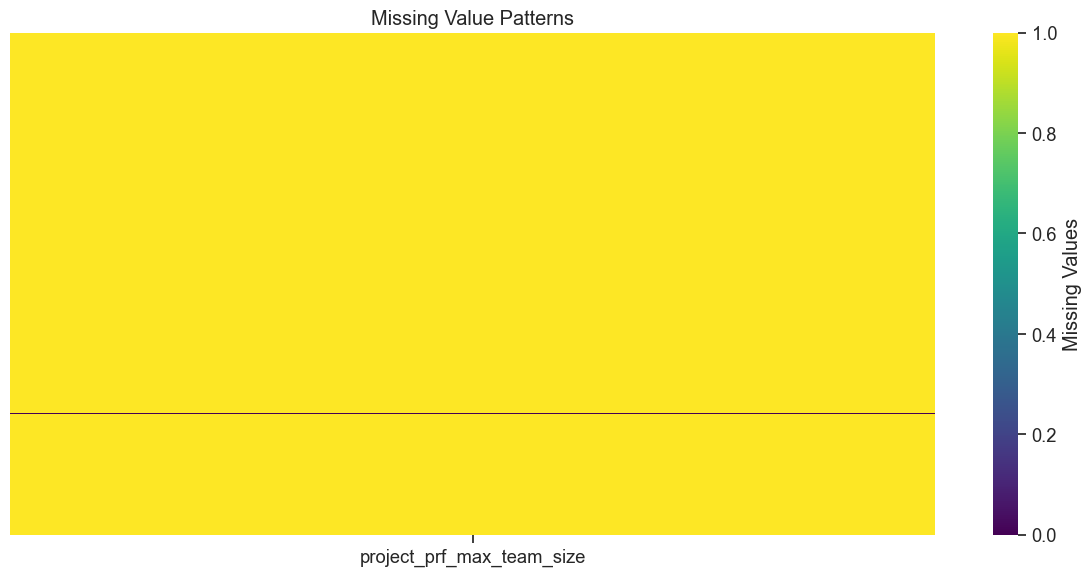

## Categorical Features

C:\Users\jdche\AppData\Local\Temp\ipykernel_30620\1448650816.py:208: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


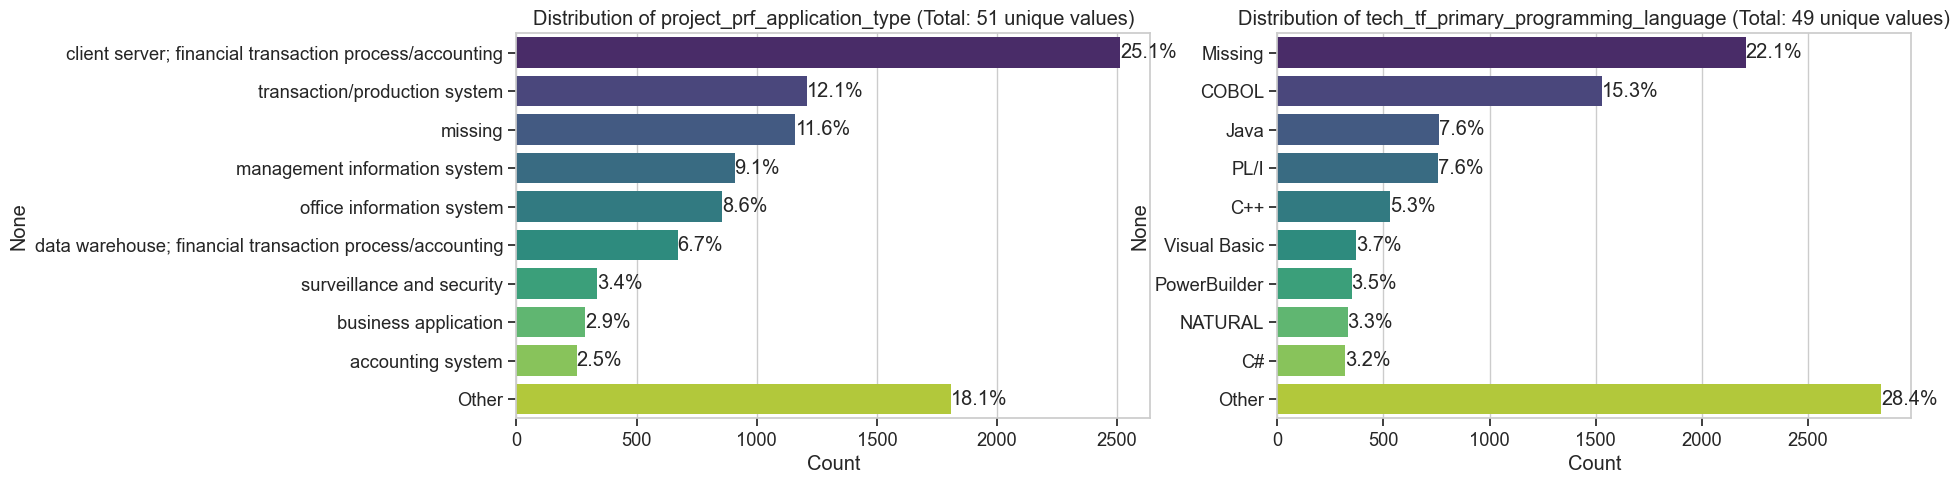

In [7]:
# Exploratory Data Analysis
explore_data(df_synthetic)



[Back to top](#Index:)

<a id='end'></a>

## End